# [Exploration 04] Movie Review Sentimental Classification
- 네이버 영화리뷰 corpus dataset을 이용해 **한국어 텍스트**의 감정분석을 한다.  

## 1. load data
- pd.read_table 을 이용해 불러온 데이터를 확인한다. 

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(train_data.document[0])
print(train_data.label[0])

train_data.info()
train_data.describe()

아 더빙.. 진짜 짜증나네요 목소리
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


,id,label
count,1.500000e+05,150000.000000
mean,6.743533e+06,0.498847
std,2.919051e+06,0.500000
min,3.300000e+01,0.000000
25%,4.766881e+06,0.000000
50%,7.526840e+06,0.000000
75%,9.249435e+06,1.000000
max,1.027815e+07,1.000000


In [3]:
print(len(train_data.document), len(train_data.label))
print(len(test_data.document), len(test_data.label))

150000 150000
50000 50000


## 2. make load_data()
- 데이터셋을 가공할 함수를 만든다. 
- **load_data()**
    - 중복 데이터 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords)제거
    - 사전 word_to_index 구성
    - 텍스트를 사전 인덱스 스트링으로 변환
    - train, test, word_to_index로 리턴

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 중복 데이터 확인 
# nunique() : 중복되지 않은 데이터의 갯수 
print(train_data['document'].nunique())  #146182

# 결측치 확인 
print(train_data.isnull().values.any()) # True 
print(test_data.isnull().values.any()) # True 
print(train_data.isnull().sum())
print(test_data.isnull().sum())

num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    # 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)   # inplace=True 는 원본에서 제거한다. 
    test_data.drop_duplicates(subset=['document'], inplace=True)   # inplace=True 는 원본에서 제거한다. 
    
    # NaN 결측치 제거 
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    
    # 결측치 재확인 
    print(train_data.isnull().values.any()) # False 
    print(test_data.isnull().values.any())  # False
    
    # 한국어 토크나이저로 토큰화(Mecab 이용)
    X_train = []
    for st in train_data['document']:
        temp_x = tokenizer.morphs(st)
        temp_x = [word for word in temp_x if not word in stopwords]   # 불용어 제거 
        X_train.append(temp_x)
        
    X_test = []
    for st in test_data['document']:
        temp_x_test = tokenizer.morphs(st)
        temp_x_test = [word for word in temp_x_test if not word in stopwords]   # 불용어 제거 
        X_test.append(temp_x_test)
        
    
    # word_to_index 만들기  
    words = np.concatenate(X_train).tolist()      # train data를 list로 만든다.
    counter = Counter(words)                      # 각 단어의 갯수와 단어를 키, 밸루로 하는 딕셔너리 생성 
    counter = counter.most_common(10000-4) 
                                       # pad, bos, unk, unused 를 제외하고 가장 자주나오는 만개의 단어를 가져온다. (딕셔너리)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링 -> 인덱스 스트링 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

146182
True
True
id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64
False
False


In [5]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

146182 49157
146182 49157


In [6]:
# index_to_word 생성 (전체파일을 생성하기 때문에 시간이 조금 걸린다)
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 데이터 분석, 가공 
- 데이터의 분포를 확인해 적절한 문장의 길이를 정한다.
- 패딩을 한다. 

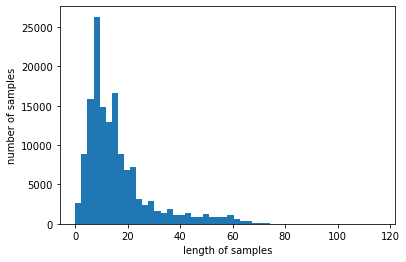

In [8]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
print("X_train's length :", len(X_train))
print("X_test's length :", len(X_test))

X_train's length : 146182
X_test's length : 49157


In [10]:
# 전체 데이터 셋 통합 
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4. 모델 설계
(1) Conv1D

In [68]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          3616      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

## 5. data split
- train_test_split을 이용해서 train, valid를 이용한다. 

In [13]:
from sklearn import model_selection

x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size = 0.1, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(131563, 41) (131563,)
(14619, 41) (14619,)


In [14]:
# 슬라이싱을 이용해서 split하는 코드 

# # validation set 10000건 분리
# x_val = X_train[:10000]   
# y_val = y_train[:10000]

# # validation set을 제외한 나머지 15000건
# partial_x_train = X_train[10000:]  
# partial_y_train = y_train[10000:]

# print(partial_x_train.shape)
# print(partial_y_train.shape)

## 6. run model

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/20
257/257 - 9s - loss: 0.4712 - accuracy: 0.7589 - val_loss: 0.3564 - val_accuracy: 0.8441
Epoch 2/20
257/257 - 1s - loss: 0.3177 - accuracy: 0.8649 - val_loss: 0.3393 - val_accuracy: 0.8547
Epoch 3/20
257/257 - 1s - loss: 0.2782 - accuracy: 0.8837 - val_loss: 0.3389 - val_accuracy: 0.8535
Epoch 4/20
257/257 - 1s - loss: 0.2379 - accuracy: 0.9049 - val_loss: 0.3532 - val_accuracy: 0.8502
Epoch 5/20
257/257 - 1s - loss: 0.1982 - accuracy: 0.9237 - val_loss: 0.3944 - val_accuracy: 0.8443
Epoch 6/20
257/257 - 1s - loss: 0.1609 - accuracy: 0.9406 - val_loss: 0.4427 - val_accuracy: 0.8421
Epoch 7/20
257/257 - 1s - loss: 0.1301 - accuracy: 0.9544 - val_loss: 0.4955 - val_accuracy: 0.8380
Epoch 8/20
257/257 - 1s - loss: 0.1076 - accuracy: 0.9635 - val_loss: 0.5509 - val_accuracy: 0.8354
Epoch 9/20
257/257 - 1s - loss: 0.0915 - accuracy: 0.9695 - val_loss: 0.6161 - val_accuracy: 0.8345
Epoch 10/20
257/257 - 1s - loss: 0.0785 - accuracy: 0.9746 - val_loss: 0.6881 - val_accuracy: 0.8327

In [16]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 1.2006 - accuracy: 0.8162
[1.200562596321106, 0.8162214756011963]


## 7. visualize model training history

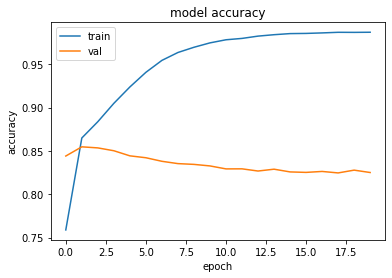

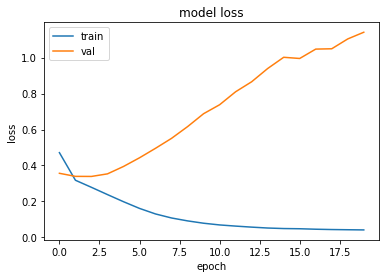

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 8. 학습된 embedding layer 분석
- model을 구성하는 첫번째 레이어는 embedding layer이다. 
- 이 레이어를 통해 학습이 잘 이루어졌는지 분석할 수 있다. 

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [19]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.00939852,  0.01526217, -0.02818016, -0.03565054,  0.07442958,
       -0.05954067,  0.00651409,  0.00411228, -0.02230202,  0.01747662,
       -0.0323615 , -0.0110852 , -0.02490189,  0.04164533,  0.00910819,
        0.00805227], dtype=float32)

In [125]:
word_vectors.similar_by_word("주인공")

[('찜찜', 0.7784051895141602),
 ('입양', 0.7557978630065918),
 ('조니', 0.75007164478302),
 ('나눠서', 0.7487185597419739),
 ('결투', 0.7368910908699036),
 ('왜곡', 0.734046220779419),
 ('흘렸', 0.7217235565185547),
 ('워', 0.7133313417434692),
 ('불과', 0.7114652395248413),
 ('화신', 0.6984989643096924)]

In [124]:
word_vectors.similar_by_word("눈물")

[('계몽', 0.9113956689834595),
 ('뿌듯', 0.9013506770133972),
 ('매트릭스', 0.9012303352355957),
 ('김현주', 0.8966587781906128),
 ('영역', 0.894691526889801),
 ('전두환', 0.888601541519165),
 ('앞서간', 0.882766604423523),
 ('들마', 0.8819926381111145),
 ('물결', 0.8810093402862549),
 ('짱짱', 0.88038569688797)]

- **'주인공'** 과 연관있는 단어를 word2vec 파일을 이용해서 뽑아낼 수있다.   
    : 하지만 관련이 없어 보이는 단어(벡터)가 출력되었다.   
    : 성능이 좋지 않다!

## 9. 한국어 word2vec embedding 활용 성능개선
- 한국어 word2vec 을 다운받아 사용한다.   
    [다운로드 경로](https://github.com/Kyubyong/wordvectors)

In [21]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = Word2Vec.load(word2vec_path)
ko_model.wv.most_similar("주인공")

[('여주인공', 0.7362918853759766),
 ('히로인', 0.7030971646308899),
 ('원작', 0.6740964651107788),
 ('악당', 0.6630157232284546),
 ('등장인물', 0.6590856909751892),
 ('악역', 0.6446496248245239),
 ('작중', 0.6274654865264893),
 ('극중', 0.6266963481903076),
 ('유령', 0.609932541847229),
 ('모험', 0.5971505641937256)]

In [126]:
ko_model.wv.most_similar("눈물")

[('땀', 0.6310575008392334),
 ('슬픔', 0.5787196159362793),
 ('이별', 0.5772002935409546),
 ('추억', 0.5725258588790894),
 ('한숨', 0.5546674728393555),
 ('슬프', 0.5339798927307129),
 ('웃음', 0.5283999443054199),
 ('울부짖', 0.5240476727485657),
 ('울음', 0.5148943066596985),
 ('온몸', 0.5059491395950317)]

### gensim 유사단어 찾기
- word2vec을 사용하지 않은 embedding layer보다 pretrained word2vec을 이용한 결과가 유사도가 높은 단어를 출력했다.  


- 해당 word2vec을 embedding layer에 적용해 기존 CNN 모델과의 성능비교를 해보고자 한다.

### embedding layer 교체

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [23]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_conv = keras.Sequential()
model_conv.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_conv.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_conv.add(keras.layers.MaxPooling1D(5))
model_conv.add(keras.layers.Conv1D(32, 7, activation='relu'))
model_conv.add(keras.layers.GlobalMaxPooling1D())
model_conv.add(keras.layers.Dense(32, activation='relu'))
model_conv.add(keras.layers.Dense(1, activation='sigmoid')) 

model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 32)             3616      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

word2vec을 적용하지 않은 모델보다 확연히 파라미터 수가 증가했다. (166,513 -> 2,027,121)

In [24]:
model_conv.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=512

history = model_conv.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
257/257 [==============================] - 11s 44ms/step - loss: 0.5317 - accuracy: 0.7226 - val_loss: 0.4275 - val_accuracy: 0.8003
Epoch 2/20
257/257 [==============================] - 6s 24ms/step - loss: 0.3800 - accuracy: 0.8317 - val_loss: 0.3814 - val_accuracy: 0.8289
Epoch 3/20
257/257 [==============================] - 6s 24ms/step - loss: 0.3236 - accuracy: 0.8618 - val_loss: 0.3622 - val_accuracy: 0.8386
Epoch 4/20
257/257 [==============================] - 6s 24ms/step - loss: 0.2901 - accuracy: 0.8789 - val_loss: 0.3472 - val_accuracy: 0.8466
Epoch 5/20
257/257 [==============================] - 6s 24ms/step - loss: 0.2649 - accuracy: 0.8917 - val_loss: 0.3602 - val_accuracy: 0.8418
Epoch 6/20
257/257 [==============================] - 6s 24ms/step - loss: 0.2413 - accuracy: 0.9034 - val_loss: 0.3684 - val_accuracy: 0.8444
Epoch 7/20
257/257 [==============================] - 7s 26ms/step - loss: 0.2189 - accuracy: 0.9142 - val_loss: 0.3900 - val_accuracy: 0.845

In [25]:
results = model_conv.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9212 - accuracy: 0.8201
[0.9211797714233398, 0.8201069831848145]


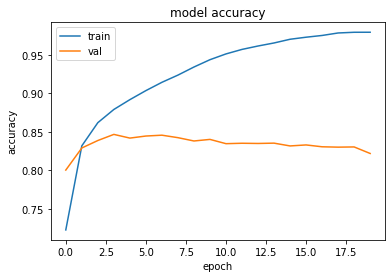

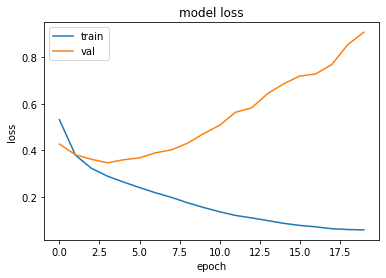

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

모든 하이퍼 파라미터가 동일한 상태에서 embedding layer를 교체하니 정확도가 높아진 것을 볼 수 있다.

## 10. 하이퍼 파라미터 튜닝을 통한 성능 개선 및 다양한 모델 사용
- 각 모델의 파라미터를 튜닝해 평가기준인 accuracy 85%이상의 성능으로 개선한다.


### CNN

In [106]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_conv_tuned = keras.Sequential()
model_conv_tuned.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_conv_tuned.add(keras.layers.Conv1D(64, 10, activation='relu'))
model_conv_tuned.add(keras.layers.GlobalMaxPooling1D())
model_conv_tuned.add(keras.layers.Dense(1, activation='sigmoid')) 

model_conv_tuned.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 32, 64)            128064    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 2,128,129
Trainable params: 2,128,129
Non-trainable params: 0
_________________________________________________________________


In [107]:
model_conv_tuned.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4
batch_size=1024

history_conv = model_conv_tuned.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
129/129 [==============================] - 11s 84ms/step - loss: 0.5928 - accuracy: 0.7057 - val_loss: 0.4861 - val_accuracy: 0.7666
Epoch 2/4
129/129 [==============================] - 5s 38ms/step - loss: 0.4150 - accuracy: 0.8130 - val_loss: 0.4210 - val_accuracy: 0.8073
Epoch 3/4
129/129 [==============================] - 5s 38ms/step - loss: 0.3358 - accuracy: 0.8575 - val_loss: 0.3857 - val_accuracy: 0.8291
Epoch 4/4
129/129 [==============================] - 5s 38ms/step - loss: 0.2849 - accuracy: 0.8837 - val_loss: 0.3747 - val_accuracy: 0.8347


In [108]:
results = model_conv_tuned.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3873 - accuracy: 0.8307
[0.38728663325309753, 0.8306853771209717]


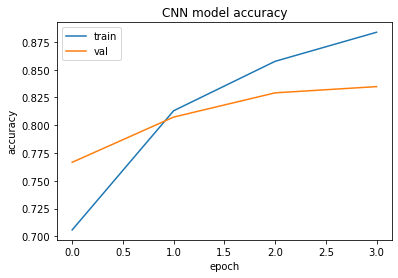

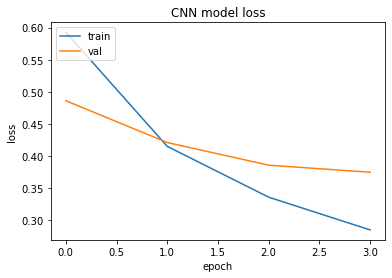

In [109]:
# summarize history for accuracy
plt.plot(history_conv.history['accuracy'])
plt.plot(history_conv.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### CNN Accuracy : 0.8306853771209717
### GlobalMaxPooling1D 1 layer

In [31]:
vocab_size = 10000
word_vector_dim = 200  

model_GMP = keras.Sequential()
model_GMP.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model_GMP.add(keras.layers.GlobalMaxPooling1D())
model_GMP.add(keras.layers.Dense(7, activation='relu'))
model_GMP.add(keras.layers.Dense(1, activation='sigmoid'))  
model_GMP.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 1407      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 8         
Total params: 2,001,415
Trainable params: 2,001,415
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_GMP.compile(optimizer=keras.optimizers.Adam(0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
batch_size=1000

history_GMP = model_GMP.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
132/132 [==============================] - 5s 36ms/step - loss: 0.6289 - accuracy: 0.6695 - val_loss: 0.4982 - val_accuracy: 0.7612
Epoch 2/10
132/132 [==============================] - 4s 34ms/step - loss: 0.4477 - accuracy: 0.7915 - val_loss: 0.4255 - val_accuracy: 0.8018
Epoch 3/10
132/132 [==============================] - 4s 34ms/step - loss: 0.3763 - accuracy: 0.8338 - val_loss: 0.3925 - val_accuracy: 0.8241
Epoch 4/10
132/132 [==============================] - 4s 34ms/step - loss: 0.3337 - accuracy: 0.8561 - val_loss: 0.3875 - val_accuracy: 0.8270
Epoch 5/10
132/132 [==============================] - 4s 34ms/step - loss: 0.2973 - accuracy: 0.8753 - val_loss: 0.3739 - val_accuracy: 0.8374
Epoch 6/10
132/132 [==============================] - 4s 33ms/step - loss: 0.2676 - accuracy: 0.8905 - val_loss: 0.3746 - val_accuracy: 0.8407
Epoch 7/10
132/132 [==============================] - 4s 32ms/step - loss: 0.2405 - accuracy: 0.9047 - val_loss: 0.3841 - val_accuracy: 0.8411

In [33]:
results = model_GMP.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4346 - accuracy: 0.8330
[0.4345972239971161, 0.832963764667511]


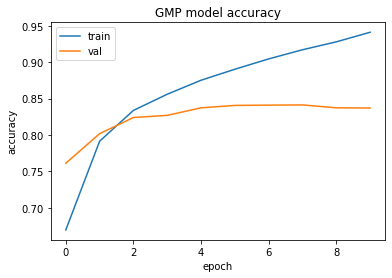

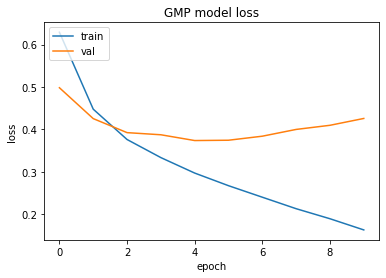

In [34]:
# summarize history for accuracy
plt.plot(history_GMP.history['accuracy'])
plt.plot(history_GMP.history['val_accuracy'])
plt.title('GMP model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_GMP.history['loss'])
plt.plot(history_GMP.history['val_loss'])
plt.title('GMP model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### GlobalMaxPooling1D 1 layer Accuracy : 0.832963764667511

### LSTM

In [35]:
vocab_size = 10000
word_vector_dim = 200  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model_LSTM.add(keras.layers.LSTM(512))   
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1460224   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 3,460,737
Trainable params: 3,460,737
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
batch_size=1000

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
132/132 [==============================] - 16s 119ms/step - loss: 0.4704 - accuracy: 0.7713 - val_loss: 0.3841 - val_accuracy: 0.8296
Epoch 2/10
132/132 [==============================] - 15s 113ms/step - loss: 0.3323 - accuracy: 0.8554 - val_loss: 0.3364 - val_accuracy: 0.8529
Epoch 3/10
132/132 [==============================] - 15s 114ms/step - loss: 0.2822 - accuracy: 0.8809 - val_loss: 0.3097 - val_accuracy: 0.8689
Epoch 4/10
132/132 [==============================] - 15s 113ms/step - loss: 0.2497 - accuracy: 0.8963 - val_loss: 0.3104 - val_accuracy: 0.8708
Epoch 5/10
132/132 [==============================] - 15s 111ms/step - loss: 0.2154 - accuracy: 0.9124 - val_loss: 0.3191 - val_accuracy: 0.8680
Epoch 6/10
132/132 [==============================] - 15s 113ms/step - loss: 0.1789 - accuracy: 0.9296 - val_loss: 0.3364 - val_accuracy: 0.8666
Epoch 7/10
132/132 [==============================] - 15s 114ms/step - loss: 0.1418 - accuracy: 0.9451 - val_loss: 0.3745 - val_ac

In [37]:
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.5664 - accuracy: 0.8590
[0.5663949251174927, 0.8589621186256409]


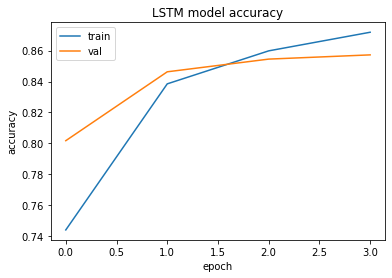

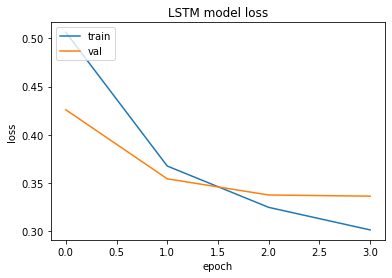

In [110]:
# summarize history for accuracy
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### LSTM Accuracy : 0.8589621186256409

### CNN + LSTM

In [112]:
vocab_size = 10000
word_vector_dim = 200  

model_CNN_LSTM = keras.Sequential()
model_CNN_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model_CNN_LSTM.add(keras.layers.Conv1D(3, 7, activation='relu'))
model_CNN_LSTM.add(keras.layers.LSTM(128))   
model_CNN_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN_LSTM.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 35, 3)             4203      
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 129       
Total params: 2,071,916
Trainable params: 2,071,916
Non-trainable params: 0
_________________________________________________________________


In [119]:
model_CNN_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4
batch_size=512

history_CNN_LSTM = model_CNN_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
257/257 [==============================] - 7s 28ms/step - loss: 0.2909 - accuracy: 0.8777 - val_loss: 0.3342 - val_accuracy: 0.8562
Epoch 2/4
257/257 [==============================] - 7s 27ms/step - loss: 0.2803 - accuracy: 0.8822 - val_loss: 0.3386 - val_accuracy: 0.8525
Epoch 3/4
257/257 [==============================] - 7s 27ms/step - loss: 0.2672 - accuracy: 0.8890 - val_loss: 0.3367 - val_accuracy: 0.8539
Epoch 4/4
257/257 [==============================] - 7s 27ms/step - loss: 0.2578 - accuracy: 0.8940 - val_loss: 0.3419 - val_accuracy: 0.8524


In [120]:
results = model_CNN_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3518 - accuracy: 0.8509
[0.3517517149448395, 0.8508859276771545]


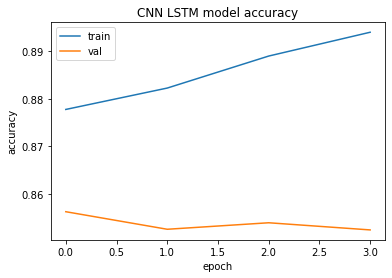

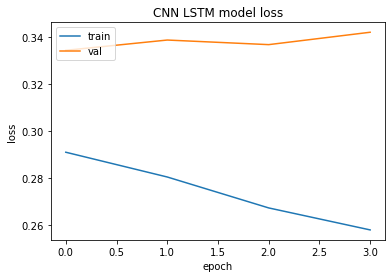

In [122]:
# summarize history for accuracy
plt.plot(history_CNN_LSTM.history['accuracy'])
plt.plot(history_CNN_LSTM.history['val_accuracy'])
plt.title('CNN LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_CNN_LSTM.history['loss'])
plt.plot(history_CNN_LSTM.history['val_loss'])
plt.title('CNN LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### CNN LSTM Accuracy : 0.8508859276771545

# 정리
---
1. 네이버 영화리뷰 dataset을 load한다.   
    - pd.read_tabel 을 이용하면 데이터를 표로 읽어올 수 있다. 
    - 데이터 description을 출력해 해당 데이터의 특성을 파악한다.
2. 데이터셋을 가공할 함수를 만든다.   
    - 중복된 데이터와 결측치를 제거한다.
    - 문장을 토크나이저로 토큰화한다. 
    - 불용어는 제거한다.
    - word_to_index, index_to_word를 구성한다.
3. 데이터의 분포를 확인해 패딩할 최대 길이를 선정한다.
    - 최대 길이는 (평균 + 2\*표준편차)로 계산하였다. (41)
4. 문장 앞에 패딩을 해 길이를 맞춘다.
5. train, valid 로 dataset을 나눈다. 
6. 모델을 설계한다.
    - 첫번째 레이어는 embedding layer로 구성한다.
7. pretrain된 word2vec을 활용해 embedding layer를 구성한다.
    - word2vec을 활용하면 단어간 유사도를 판별할 수 있다.
8. 학습시킨 후 그래프 시각화를 통해 과적합을 판별해 파라미터를 조정한다.


# 루브릭 평가
---
1. **다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.**   
    - convolution 1-dimension layer : 0.8306853771209717
    - Global Max Pooling 1-layer : 0.832963764667511
    - LSTM : 0.8589621186256409
    - CNN+LSTM : 0.8508859276771545  
    
    
2. **gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.**  
    - '주인공', '눈물' 각 단어의 유사단어를 출력해 사전학습된 임베딩 레이어의 성능을 확인했다.  
    
    
3. **한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.**  
    - LSTM, CNN+LSTM 모델의 accuracy를 85% 이상 달성했다.

    
# 회고
---
## 더 공부하고 싶은 부분
- embedding layer의 원리
- lstm 연산
- vector dimension
- callback함수를 사용해 earlystopping하는 것과 그래프로 확인해 에폭을 줄이는 것의 성능차이가 있을까?  

## 느낀 점
아직 RNN, NLP에 대해 부족한 부분이 많아 연산을 생각하며 모델을 구성하지 못한 점이 아쉬웠다. 문장을 토큰화하고, 벡터화하고 여러 전처리 과정에서 문장의 의미, 맥락, 단어들의 유사도 등 의미있는 데이터를 손상하지 않기위한 고민이 많이 필요하다는 것을 알게되었다. 더 재미있는 task도 빨리 만나고 싶다.